# Test Env

Import data.

In [ ]:
%load_ext autoreload
%autoreload 2

import dgym as dg
from dgym.collection import MoleculeCollection, ReactionCollection

# load all data
print('load data')
path = '../dgym-data'

deck = MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
load data
align fingerprints


In [ ]:
from dgym.envs.library_designer import LibraryDesigner

library_designer = LibraryDesigner(
    repertoire, # reactions
    building_blocks,
    fingerprints
)

In [159]:
drug_env.action_mask.sum()

9980

In [209]:
from dgym.collection import ReactionCollection



[autoreload of dgym.collection failed: Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/IP

In [180]:
from dgym.envs import DrugEnv

drug_env = DrugEnv(library_designer, library=list(deck[:6]))
# is there data associated with the library? could be.

action = {
    'design': {
        'selected_molecules': [0, 1],
        'num_analogs': 2,
        'percent_random': 1.0
        # fraction_random
    }
}

= drug_env.step(action)
# [display(p) for p in drug_env.library[6:]]

([<dgym.molecule.Molecule at 0x7f3549abd310>,
 None,
 None,
 {})

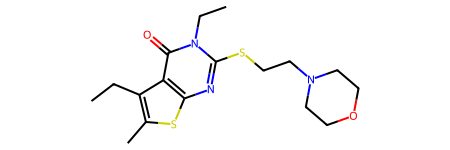

In [207]:
Out[180][0][-11]

In [167]:
from dgym.agents import DrugAgent

In [170]:
drug_agent = DrugAgent(drug_env.action_space)

In [179]:
drug_agent.act()

TypeError: DrugAgent.act() missing 2 required positional arguments: 'observations' and 'mask'